**Обнаружение мошенничества с кредитными картами(Kaggle)**


В этом наборе данных представлены транзакции, которые произошли за два дня, из которых у нас 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничество) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем с конфиденциальностью мы не можем предоставить исходные функции и дополнительную справочную информацию о данных. Характеристики V1, V2,… V28 - это основные компоненты, полученные с помощью PCA, единственными функциями, которые не были преобразованы с помощью PCA, являются «Время» и «Количество». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Сумма» - это сумма транзакции, эта функция может использоваться для обучения с учетом затрат и затрат. Функция «Класс» - это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

**Метрики точности**

recall_score -  полнота(доля вычесленных мошеннических операций). 
precision_score -  точность(доля мошеннических операций среди ТА, отмеченных как мошеннические, учитывает ложные срабатывания. чем ниже точность, тем больше клиентов мы тревожим для перепроверки статуса ТА, что может вызывать  их недовольство). 
f1_scores - средневзвешенная оценка между полнотой и точностью 

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, average_precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Perm_IT_Univer/ML/Final_work/creditcard.csv')
data.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


 Первичный анализ данных

In [3]:
data.describe().round(7)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001728
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814040,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403633,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214326,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070839,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019846,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027195,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [4]:
# проверка на пропуски в данных
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

доля мошеннических транзакций в общей выборке -  0.17 %
доля суммы мошеннических транзакций в общей сумме -  0.24 %


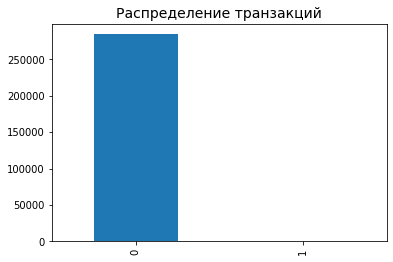

In [5]:
print('доля мошеннических транзакций в общей выборке - ', round(data['Class'].mean()*100, 2), '%')
amount = data.groupby(by=['Class'])['Amount'].sum().round(2)
fraud = amount[1]/(amount[1]+amount[0])*100
print('доля суммы мошеннических транзакций в общей сумме - ', fraud.round(2), '%')
data['Class'].value_counts().plot(kind='bar')
plt.title('Распределение транзакций', fontsize=14)
plt.show()

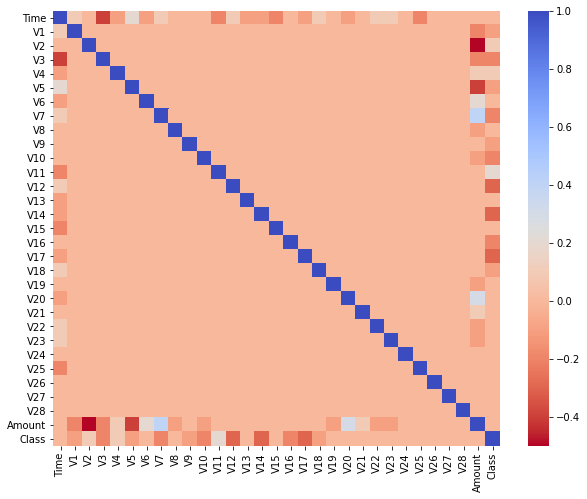

In [9]:
# корреляция между признаками 
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().round(1), cmap='coolwarm_r')
plt.show()

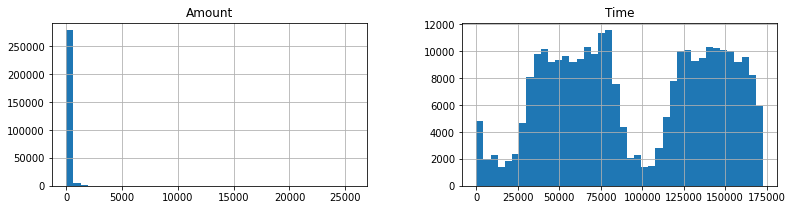

In [11]:
data[['Amount','Time']].hist(bins = 40, figsize=(13,3))
plt.show()

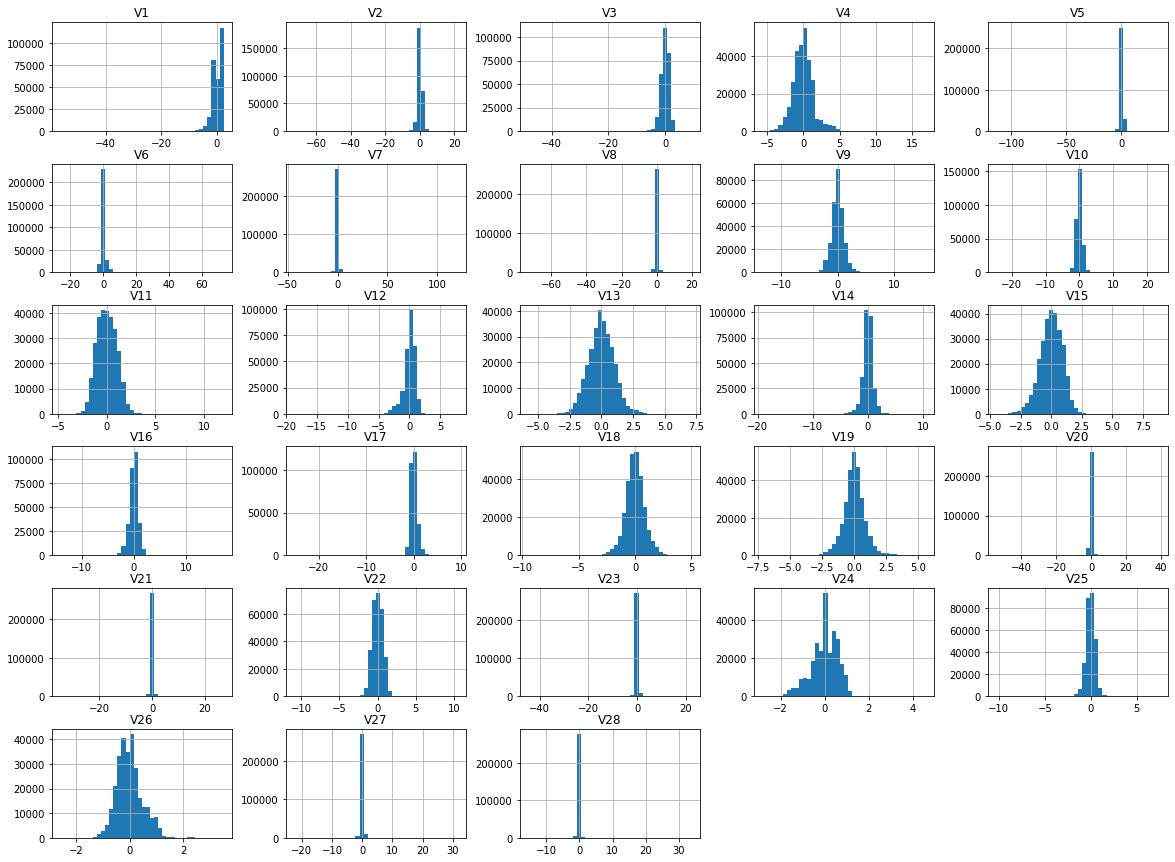

In [12]:
data.drop(columns=['Time','Amount','Class']).hist(bins = 40, figsize=(20,15))
plt.show()

Стандартизация суммы транзакций

In [3]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time'],axis=1)
data.describe().round(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000
mean,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00173
std,1.95870,1.65131,1.51626,1.41587,1.38025,1.33227,1.23709,1.19435,1.09863,1.08885,1.02071,0.99920,0.99527,0.95860,0.91532,0.87625,0.84934,0.83818,0.81404,0.77093,0.73452,0.72570,0.62446,0.60565,0.52128,0.48223,0.40363,0.33008,1.00000,0.04153
min,-56.40751,-72.71573,-48.32559,-5.68317,-113.74331,-26.16051,-43.55724,-73.21672,-13.43407,-24.58826,-4.79747,-18.68371,-5.79188,-19.21433,-4.49894,-14.12985,-25.16280,-9.49875,-7.21353,-54.49772,-34.83038,-10.93314,-44.80774,-2.83663,-10.29540,-2.60455,-22.56568,-15.43008,-0.35323,0.00000
25%,-0.92037,-0.59855,-0.89036,-0.84864,-0.69160,-0.76830,-0.55408,-0.20863,-0.64310,-0.53543,-0.76249,-0.40557,-0.64854,-0.42557,-0.58288,-0.46804,-0.48375,-0.49885,-0.45630,-0.21172,-0.22839,-0.54235,-0.16185,-0.35459,-0.31715,-0.32698,-0.07084,-0.05296,-0.33084,0.00000
50%,0.01811,0.06549,0.17985,-0.01985,-0.05434,-0.27419,0.04010,0.02236,-0.05143,-0.09292,-0.03276,0.14003,-0.01357,0.05060,0.04807,0.06641,-0.06568,-0.00364,0.00373,-0.06248,-0.02945,0.00678,-0.01119,0.04098,0.01659,-0.05214,0.00134,0.01124,-0.26527,0.00000
75%,1.31564,0.80372,1.02720,0.74334,0.61193,0.39856,0.57044,0.32735,0.59714,0.45392,0.73959,0.61824,0.66250,0.49315,0.64882,0.52330,0.39967,0.50081,0.45895,0.13304,0.18638,0.52855,0.14764,0.43953,0.35072,0.24095,0.09105,0.07828,-0.04472,0.00000
max,2.45493,22.05773,9.38256,16.87534,34.80167,73.30163,120.58949,20.00721,15.59499,23.74514,12.01891,7.84839,7.12688,10.52677,8.87774,17.31511,9.25353,5.04107,5.59197,39.42090,27.20284,10.50309,22.52841,4.58455,7.51959,3.51735,31.61220,33.84781,102.36224,1.00000


Разделение данных на трэйн и тест выборки с сохранением баланса классов

In [4]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=241, stratify = data['Class'])

X_train = data_train.drop(columns='Class')
y_train = data_train['Class']
X_test = data_test.drop(columns='Class')
y_test = data_test['Class']

skf = StratifiedKFold(n_splits=5)

print('доля мошен. ТА в тренировочной выборке - ',y_train.mean()*100)
print('доля мошен. ТА в тестовой выборке - ',y_test.mean()*100)

доля мошен. ТА в тренировочной выборке -  0.17254870488152324
доля мошен. ТА в тестовой выборке -  0.17321489179921118


In [5]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

LogisticRegression 
Точность на кросс-валидации -  87.01643884570714 %
recall_score -  60.810810810810814 %
precision_score -  90.0 %
f1_score -  72.58064516129032 %


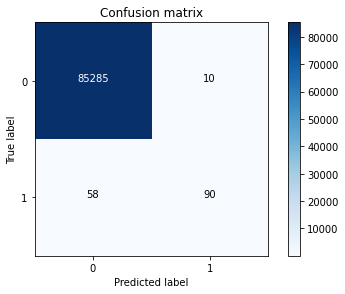

In [6]:
LR = LogisticRegression(penalty='l2', C=0.1)
training_score = cross_val_score(LR, X_train, y_train, cv=skf, scoring='precision')
print('LogisticRegression \nТочность на кросс-валидации - ', training_score.mean()*100, '%')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
print('recall_score - ',recall_score(y_test,y_pred)*100, '%')
print('precision_score - ',precision_score(y_test,y_pred)*100, '%')
print('f1_score - ',f1_score(y_test,y_pred)*100, '%')

cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Не смотря на то, что precision_score достаточно высока (90%), recall_score низкая - всего 60% мошеннических ТА отлавиливается, 40% мошеннических ТА проходит.
Увеличим вес fraud-класса в логистической регрессии



LogisticRegression 
Точность на кросс-валидации -  6.410354544163438 %
recall_score -  91.8918918918919 %
precision_score -  6.861755802219979 %
f1_score -  12.769953051643194 %


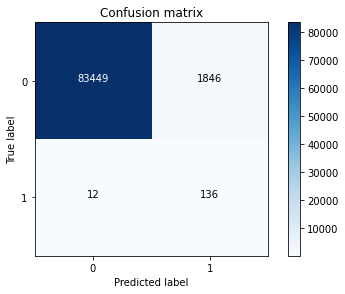

In [7]:
LR = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced')
training_score = cross_val_score(LR, X_train, y_train, cv=skf, scoring='precision')
print('LogisticRegression \nТочность на кросс-валидации - ', training_score.mean()*100, '%')
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
print('recall_score - ',recall_score(y_test,y_pred)*100, '%')
print('precision_score - ',precision_score(y_test,y_pred)*100, '%')
print('f1_score - ',f1_score(y_test,y_pred)*100, '%')

cnf_matrix = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Сейчас же видми, что отлавливается 92% мошеннических ТА, но при этом доля ложных срабатываний достаточно высока - порядка 2% (= 1846/(83449+1846)).

Попробуем сбалансировать класс способом oversampling



In [8]:
import math
# балансировка класса

data_train_balance = data_train
sample = data_train[data_train['Class'] == 1]
              
n = math.floor(len(data_train[data_train['Class'] == 0]) / len(sample))

for i in range(1,n):
  data_train_balance = data_train_balance.append(sample)
print(data_train_balance['Class'].mean())
X_oversample = data_train_balance.drop(columns=['Class'])
y_oversample = data_train_balance['Class']
X_oversample.head()

0.4997637312367413


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
150966,-1.196474,2.221307,-0.141872,1.042105,1.511307,-0.463378,1.428295,-0.266843,0.701832,-0.490084,0.416278,-2.955837,1.451236,0.163364,-0.628026,-0.784416,2.101479,0.551043,0.444674,0.369964,-0.292173,-0.198129,-0.530381,0.500426,1.285608,-0.236888,0.368837,0.263676,-0.315248
17860,1.080457,0.104477,0.506949,1.498882,-0.356456,-0.367287,0.107342,-0.037015,0.289030,-0.135086,-0.270520,0.555154,-0.341732,0.124359,-0.097293,-0.807327,0.392822,-1.059536,-0.500081,-0.147258,-0.062917,-0.024826,-0.048162,0.405550,0.602309,-0.335271,0.033395,0.024381,-0.193426
266425,-1.174103,-0.222169,1.099893,-2.984348,-0.834085,-0.700750,-0.398882,0.476014,-2.587653,0.545774,0.433658,-0.472356,-0.102464,0.027402,-1.466902,-0.221902,0.336555,0.392070,-0.531937,-0.251275,-0.088025,-0.045038,-0.303128,-0.013722,0.734685,-0.122800,0.132203,-0.005853,-0.238085
270251,1.739685,0.275180,-0.275486,3.875484,0.072522,-0.021289,0.111038,-0.129964,-0.840767,1.350604,-1.118852,0.389146,1.198682,-0.169379,-0.749309,0.978775,-0.933694,-0.422826,-1.604755,-0.041396,0.074649,0.135239,0.137319,-0.032959,-0.178674,-0.108454,-0.021697,-0.021699,0.010716
164263,2.048411,-0.020305,-1.811533,0.264733,0.430279,-0.468631,-0.040305,0.023121,0.510844,-0.157951,0.635234,-0.155838,-1.704601,-0.318527,-0.289757,0.659329,0.239232,0.472534,0.439302,-0.249777,-0.348093,-1.014410,0.320947,0.209112,-0.316125,0.174045,-0.077913,-0.046770,-0.349671


In [10]:
#X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_oversample, y_oversample, test_size=0.33, random_state=42)
X_train_os = X_oversample
y_train_os = y_oversample

In [11]:
LR = LogisticRegression(penalty='l2', C=0.1)

training_score = cross_val_score(LR, X_train_os, y_train_os, cv=5, scoring='precision')
print('LogisticRegression \nТочность на кросс-валидации - ', training_score.mean()*100, '%')
LR.fit(X_train_os,y_train_os)
y_predict = LR.predict(X_test)
print('recall_score - ',recall_score(y_test,y_predict)*100, '%')
print('precision_score - ',precision_score(y_test,y_predict)*100, '%')
print('f1_score - ',f1_score(y_test,y_predict)*100, '%')

LogisticRegression 
Точность на кросс-валидации -  97.66546198205101 %
recall_score -  91.21621621621621 %
precision_score -  6.80786686838124 %
f1_score -  12.670107930549038 %


Полученный результат соответствует результату обучения логистической регрессии на исходном тренировочном датасэте с увеличением веса fraud-класса.

Попробуем применить IsolationForest

На первом этапе используем IsolationForest как кластеризатор - передадим модели весь датасэт ипосмотрим как она разделит его на кластеры (0,83 - обычные ТА и 0,17 - fraud ТА)

recall_score -  45.1219512195122 %
precision_score -  45.1219512195122 %
f1_score -  45.1219512195122 %


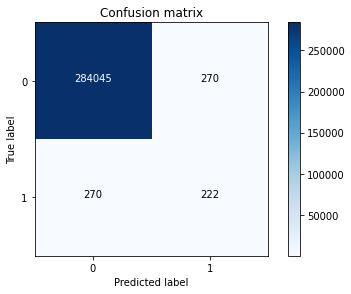

In [12]:
X = data.drop(columns=['Class'])
y = data.Class

IF = IsolationForest(n_estimators=65, max_samples=len(data), random_state=142, contamination=y.mean(), max_features=1, bootstrap=True)
IF.fit(X)
y_predict = pd.Series(IF.predict(X)).replace({-1: 1, 1: 0})

print('recall_score - ',recall_score(y, y_predict)*100, '%')
print('precision_score - ',precision_score(y, y_predict)*100, '%')
print('f1_score - ',f1_score(y, y_predict)*100, '%')

cnf_matrix = confusion_matrix(y, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Как видим, результат самый худший из всех

Теперь попробуем использовать IsolationForest как детектор аномалий, обучив его на корректных ТА

recall_score -  84.34959349593495 %
precision_score -  2.586959232015958 %
f1_score -  5.019958872626104 %


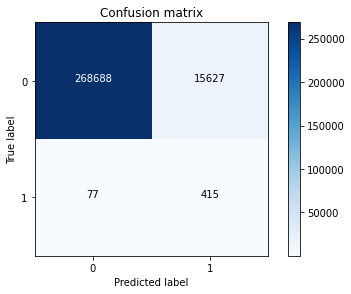

In [13]:
X_0 = data[data['Class']==0].drop(columns=['Class'])
y_0 = data[data['Class']==0]['Class']
X_1 = data[data['Class']==1].drop(columns=['Class'])
y_1 = data[data['Class']==1]['Class']

IF = IsolationForest(random_state=142, max_features=1, bootstrap=True)

IF.fit(X_0)
y_predict_0 = pd.Series(IF.predict(X_0)).replace({-1: 1, 1: 0})
y_predict_1 = pd.Series(IF.predict(X_1)).replace({-1: 1, 1: 0})

y=y_0.append(y_1)
y_predict=y_predict_0.append(y_predict_1)

print('recall_score - ',recall_score(y, y_predict)*100, '%')
print('precision_score - ',precision_score(y, y_predict)*100, '%')
print('f1_score - ',f1_score(y, y_predict)*100, '%')

cnf_matrix = confusion_matrix(y, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Результат уже лучше, но все равно хуже чем логистическая регрессия

Попробуем XGBoost

In [ ]:
XGB = xgb.XGBClassifier(n_jobs=-1)

param_grid = {'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.05, 0.1, 0.2, 0.5],
              'n_estimators': [100, 200, 300]
              }

CV_XGB = GridSearchCV(estimator = XGB, param_grid = param_grid, scoring ='f1', verbose = 2)
CV_XGB.fit(X_train, y_train)

best_parameters = CV_XGB.best_params_
print(best_parameters)

In [30]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
18273,1.164559,0.217913,-0.752113,1.328143,2.212821,3.789840,-0.475359,0.918017,-0.824578,0.700439,-0.245811,-0.182284,0.051641,0.388880,0.784043,1.167213,-1.169303,-0.035019,-0.554699,0.048114,-0.328816,-1.265124,0.123105,0.936876,0.313643,-0.316940,-0.005618,0.031222,-0.198304
137467,1.099223,-0.480621,0.557589,-0.655925,-0.991028,-0.738770,-0.287613,-0.022480,1.611199,-1.108716,0.027190,0.738786,-0.513369,0.151853,1.330647,-1.056877,0.381998,-0.479190,0.153560,-0.086192,0.073263,0.357989,-0.074523,0.429113,0.528734,-0.621323,0.076730,0.035088,-0.127457
27104,-0.447795,0.904956,-0.150873,-0.146819,0.506212,0.861333,0.388258,0.577189,-0.799234,-0.251297,-0.090522,0.182624,0.003241,0.798751,0.738416,0.464113,-0.541722,0.035322,1.403913,-0.113921,-0.391162,-1.332594,0.242039,-1.751273,-0.616538,0.089477,-0.196681,-0.082277,-0.077761
232349,-1.309939,0.074248,-0.184931,-1.443318,0.619961,-0.749945,0.663078,0.311258,0.106494,-1.234384,0.033635,1.222915,0.069400,0.375382,-2.136591,0.290342,-0.843438,-0.114319,-0.650048,-0.400221,0.064934,0.072203,-0.160822,-0.363762,-0.632555,-0.429745,0.014603,-0.014717,-0.031104
191168,1.878563,0.020785,-1.621113,2.908813,2.507847,4.709442,-0.830626,1.136154,-0.395755,1.311413,-0.945685,-0.007911,-0.341914,-0.121324,-1.531388,0.303652,-0.471434,-0.592712,-1.388681,-0.252053,0.079998,0.404327,0.121098,0.707538,0.140100,0.155684,0.016375,-0.053892,-0.353229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68711,-5.977224,-3.569302,-1.594619,0.750106,-0.289605,-1.991264,0.159329,1.023878,-0.091353,-0.842583,-0.348546,1.128343,0.589593,0.919332,-0.142391,0.109939,0.639635,-1.143753,-0.859672,-0.098459,0.027281,0.217545,0.746719,0.780580,-0.299380,0.844621,0.836501,-1.202044,-0.095353
96072,1.237670,0.371992,0.209124,0.488730,-0.055993,-0.531955,0.048931,-0.095850,-0.365577,-0.144605,1.515574,1.379891,1.264781,-0.322903,0.301051,0.722358,-0.438256,0.174445,0.209758,0.009391,-0.245608,-0.691713,0.062851,-0.013325,0.266579,0.094087,-0.020367,0.019547,-0.346073
270524,-0.802964,1.514337,-1.632704,-0.820419,0.730268,-0.133280,0.100090,0.979918,-0.330370,-0.794968,-0.158517,0.401513,-0.154481,-0.238272,-0.888252,1.045474,0.126025,0.690189,0.373351,-0.043061,-0.298967,-0.974562,0.094177,-0.415373,-0.239619,0.162513,0.079056,-0.021893,-0.317287
230125,-6.387213,1.610530,-4.098727,-0.423258,-1.507861,-0.197284,-1.127728,1.165630,0.900729,-0.319586,-0.278846,0.684712,-1.064816,-0.048508,-0.823575,1.249854,1.420527,1.018574,0.482209,-1.885887,0.511960,-1.006312,-0.010422,0.091558,0.322616,-0.293195,-2.702723,-0.581929,-0.194226


LogisticRegression 
Точность на кросс-валидации -  92.46027026134072 %
recall_score -  79.05405405405406 %
precision_score -  94.35483870967742 %
f1_score -  86.02941176470588 %


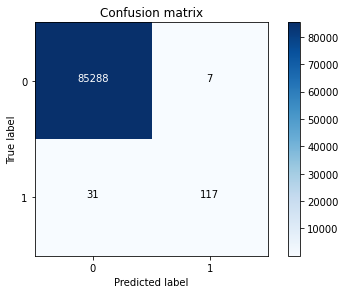

In [31]:
XGB = xgb.XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=100, n_jobs=-1, random_state=142)
training_score = cross_val_score(XGB, X_train, y_train, cv=skf, scoring='precision')
print('LogisticRegression \nТочность на кросс-валидации - ', training_score.mean()*100, '%')
XGB.fit(X_train,y_train)
y_pred = XGB.predict(X_test)
print('recall_score - ',recall_score(y_test,y_pred)*100, '%')
print('precision_score - ',precision_score(y_test,y_pred)*100, '%')
print('f1_score - ',f1_score(y_test,y_pred)*100, '%')

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Результат достаточно хороший - 80% мошеннических ТА отлавливается, при это доля ложных срабатываний низкая. Если для заказчика важно как можно меньше тревожить своих клиентов, то можно использовать данный алгоритм. Если ему важнее отловить как можно больше мошеннических ТА, то нужно использовать LogusticRegression с учетом баланса классов.